In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from hyperopt import hp, fmin, tpe

In [2]:
# import the data
game_results = pd.read_csv("champions_league_rawData.csv")

# Tidy the Data

### Identify the date of each match

In [3]:
# separate the match month, day, and time
game_results[['day', 'month', 'start_time']] = game_results.pop('match_time').str.split('.', expand=True)
game_results[['day', 'month']] = game_results[['day', 'month']].astype('int64')

In [4]:
# identify the year of the match
# note: July (month 7) always separates the beginning and end of successive seasons in the water polo Champions League
game_results[['a', 'b']] = game_results['season'].str.split('/', expand=True)
game_results['year'] = np.where(game_results['month'] > 7, game_results['a'], game_results['b'])
game_results.drop(['a', 'b'], axis=1, inplace=True)

In [5]:
# combine the day, month, year into a datetime variable
game_results['date'] = pd.to_datetime(game_results[['day', 'month', 'year']])

### Remove the qualification matches from the data set

In [6]:
from collections import Counter
#Counter(df.event_name)

In [7]:
# remove the qualifying round matches
game_results = game_results[~game_results['event_name'].str.contains('Qualification')]

In [8]:
#df.groupby(['event_name', 'event_round'], dropna=False).size()

In [9]:
# list of 'event_round' values for which a draw is not a possible result
no_draws_round = ['Final', '5th place', '7th place', 
                  'Semi-finals', '3rd place', 'Quarter-finals']

In [10]:
# record whether a draw is a possible result for each match
game_results['draw_possible'] = np.where(game_results['event_round'].isin(no_draws_round), 0, 1)

# Calculate Elo Ratings

Some of the code in this section is adapted from https://github.com/danielguerreros/InternationalELo/blob/main/calculate_elo.ipynb and https://betfair-datascientists.github.io/modelling/soccerEloTutorialR/

In [11]:
# set elo parameter values
elo_start = 1500
elo_width = 400
val_seasons = ['2021/2022', '2022/2023'] #data to use as validation when tuning k

In [12]:
# remove columns not needed to compute elo
df_elo = game_results.drop(['event_name',
                            'event_round', 
                            'day', 
                            'month', 
                            'start_time', 
                            'year'], axis=1)

# sort matches chronologically since elo is a form of time series analysis
df_elo.sort_values(by=['season', 'date'], inplace=True)

# include indicators for the game outcomes (win, loss, or draw) in the data set
outcomes = [df_elo['home_score'] > df_elo['away_score'],
            df_elo['home_score'] < df_elo['away_score'],
            df_elo['home_score'] == df_elo['away_score']]
df_elo['actual_home'] = np.select(outcomes, [1,0,0])
df_elo['actual_away'] = np.select(outcomes, [0,1,0])
df_elo['actual_draw'] = np.select(outcomes, [0,0,1])

In [13]:
# function to calculate the expected result from teams' current elo ratings
def expected_result(home_elo, away_elo):
    diff = home_elo - away_elo
    exp_res = 1/(1+10**(-diff/elo_width))
    return [exp_res, 1-exp_res]

# function to assign weights for the outcome of the match
def actual_result(home_score, away_score):
    if home_score > away_score:
        wh = 1
        wa = 0
    elif home_score < away_score:
        wh = 0
        wa = 1
    elif home_score == away_score:
        wh = 0.5
        wa = 0.5
    return [wh, wa]

# function to update elo ratings for the current match results
def calculate_elo(elo_home, elo_away, home_score, away_score, k=40):
    wh, wa = actual_result(home_score, away_score)
    exp_home, exp_away = expected_result(elo_home, elo_away)

    rating_home = elo_home + k*(wh-exp_home)  ##use another multiplier on the last term here to account for goal differential
    rating_away = elo_away + k*(wa-exp_away)

    return [rating_home, rating_away, exp_home, exp_away]

### Tune the k Value

In [14]:
def objective(k):
    """Objective function to minimize using hyperopt"""
    
    current_elo={}
    df = df_elo.copy()

    for idx, row in df.iterrows():
        
        home = row['home_team']
        away = row['away_team']
    
        # initially assign a default rating for each team
        if home not in current_elo.keys():
            current_elo[home] = elo_start
        if away not in current_elo.keys():
            current_elo[away] = elo_start
    
        # record elo before match
        df.loc[idx,'Elo_h_before'] = np.round(current_elo[home], 1)
        df.loc[idx,'Elo_a_before'] = np.round(current_elo[away], 1)
    
        # calculate new elo from match result and record predicted match results
        [elo_h_new, 
         elo_a_new,  
         df.loc[idx,'pred_home'], 
         df.loc[idx,'pred_away']] = calculate_elo(current_elo[home], 
                                                  current_elo[away], 
                                                  row['home_score'], 
                                                  row['away_score'], 
                                                  k)

        # update current elo value
        current_elo[home] = elo_h_new
        current_elo[away] = elo_a_new
        
    # find the historical draw rates, bucketing into 5% increments of the home team's elo win probability
    # this section was inspired by https://betfair-datascientists.github.io/modelling/soccerEloTutorialR/
    draw_rates = pd.DataFrame(df.loc[df['draw_possible']==1, ['actual_draw', 'pred_home']])
    draw_rates['prob_bucket'] = round(draw_rates['pred_home']*20)/20
    draw_rates = draw_rates.groupby('prob_bucket')['actual_draw'].agg(['sum','count'])
    draw_rates['draw_prob'] = draw_rates['sum']/draw_rates['count']

    # adjust the winning odds to account for draws
    df['pred_draw'] = df.apply(lambda x: draw_rates.loc[round(x['pred_home']*20)/20, 'draw_prob'] * x['draw_possible'], axis=1)
    df['pred_home'] = (1-df['pred_draw'])*df['pred_home']
    df['pred_away'] = (1-df['pred_draw'])*df['pred_away']
    
    # find the log loss, using the last couple of seasons as the validation set
    preds = df.loc[df['season'].isin(val_seasons), ['pred_home','pred_away','pred_draw']].to_numpy()
    actual = df.loc[df['season'].isin(val_seasons), ['actual_home','actual_away','actual_draw']].to_numpy()
        
    return log_loss(actual, preds)

In [15]:
# create the domain space
space = hp.quniform('k', 1, 100, 1)

# use hyperopt to optimized hyperparameter: k
best=fmin(objective, space=space, algo=tpe.suggest, max_evals=100)

print(best)

100%|██████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/trial, best loss: 0.7111370574953592]
{'k': 76.0}


### Calculate Elo with Optimized k Value

In [16]:
current_elo={}

for idx, row in df_elo.iterrows():
    
    home = row['home_team']
    away = row['away_team']
    
    # initially assign a default rating for each team
    if home not in current_elo.keys():
        current_elo[home] = elo_start
    
    if away not in current_elo.keys():
        current_elo[away] = elo_start
    

    # record elo before match
    df_elo.loc[idx,'Elo_h_before'] = np.round(current_elo[home], 1)
    df_elo.loc[idx,'Elo_a_before'] = np.round(current_elo[away], 1)
    
    # calculate new elo from match result and record predicted match results, using optimized k value
    [elo_h_new, 
     elo_a_new,  
     df_elo.loc[idx,'pred_home'], 
     df_elo.loc[idx,'pred_away']] = calculate_elo(current_elo[home],
                                                  current_elo[away], 
                                                  row['home_score'], 
                                                  row['away_score'], 
                                                  best['k'])

    # update current elo value
    current_elo[home] = elo_h_new
    current_elo[away] = elo_a_new
    
    # record post-match elo
    df_elo.loc[idx,'Elo_h_after'] = np.round(elo_h_new, 1)
    df_elo.loc[idx,'Elo_a_after'] = np.round(elo_a_new, 1)

### Account for the Possibility of Draws in Elo Calculations 

In [17]:
# include predicted and actual game win probabilities in dataset
outcomes = [df_elo['home_score'] > df_elo['away_score'],
            df_elo['home_score'] < df_elo['away_score'],
            df_elo['home_score'] == df_elo['away_score']]
df_elo['actual_home'] = np.select(outcomes, [1,0,0])
df_elo['actual_away'] = np.select(outcomes, [0,1,0])
df_elo['actual_draw'] = np.select(outcomes, [0,0,1])

df_elo[['pred_home', 'pred_away']] = df_elo.apply(lambda x: expected_result(x['Elo_h_before'], x['Elo_a_before']), axis=1, result_type='expand')

# find the historical draw rates, bucketing into 5% increments of the home team's elo win probability
draw_rates = pd.DataFrame(df_elo.loc[df_elo['draw_possible']==1, ['actual_draw', 'pred_home']])
draw_rates['prob_bucket'] = round(draw_rates['pred_home']*20)/20
draw_rates = draw_rates.groupby('prob_bucket')['actual_draw'].agg(['sum','count'])
draw_rates['draw_prob'] = draw_rates['sum']/draw_rates['count']

# adjust the winning odds to account for draws
df_elo['pred_draw'] = df_elo.apply(lambda x: draw_rates.loc[round(x['pred_home']*20)/20, 'draw_prob'] * x['draw_possible'], axis=1)
df_elo['pred_home'] = (1-df_elo['pred_draw'])*df_elo['pred_home']
df_elo['pred_away'] = (1-df_elo['pred_draw'])*df_elo['pred_away']

In [18]:
# save data by exporting to a cvs file
df_elo.to_csv('champions_league_eloData.csv', index=False)

# Calculate the Expected Win Odds for Scheduled Matches with Elo

In [19]:
# convert dict of current elo ratings into a dataframe
current_elo_df = pd.DataFrame(current_elo.items(), columns=['team', 'elo_rating']).set_index('team')
#current_elo_df.sort_values(by='elo_rating', ascending=False)

In [20]:
# read in the scheduled matches
df_scheduled = pd.read_csv("champions_league_scheduledGames.csv")

In [21]:
# calculate the Elo odds of each team winning scheduled matches
df_scheduled['home_elo'] = df_scheduled.apply(lambda x: current_elo_df.loc[x['home_team']], axis=1)
df_scheduled['away_elo'] = df_scheduled.apply(lambda x: current_elo_df.loc[x['away_team']], axis=1)
df_scheduled[['home_win_odds', 'away_win_odds']] = df_scheduled.apply(lambda x: expected_result(x['home_elo'], x['away_elo']), axis=1, result_type='expand')

# adjust the odds to account for the (historical) probability of a draw
df_scheduled['draw_possible'] = np.where(df_scheduled['event_round'].isin(no_draws_round), 0, 1)
df_scheduled['draw_odds'] = df_scheduled.apply(lambda x: draw_rates.loc[round(x['home_win_odds']*20)/20 * x['draw_possible'], 'draw_prob'], axis=1)
df_scheduled['home_win_odds'] = (1-df_scheduled['draw_odds'])*df_scheduled['home_win_odds']
df_scheduled['away_win_odds'] = (1-df_scheduled['draw_odds'])*df_scheduled['away_win_odds']

In [22]:
# save data by exporting to a cvs file
df_scheduled.to_csv('champions_league_scheduledOdds.csv', index=False)

# Create Time Series of Elo Ratings

In [23]:
# reorganize data into a time series of elo rating for all teams
home = df_elo[['date', 
               'home_team', 
               'Elo_h_after', 
               'away_team', 
               'away_score', 
               'home_score']].rename(columns={'home_team':'team','Elo_h_after':'elo', 'away_team':'opponent'})
home['result'] = np.select([home['home_score']>home['away_score'], 
                            home['home_score']==home['away_score'],
                            home['home_score']<home['away_score']],
                           ['W', 'D', 'L'])
home['score'] = home['home_score'].astype('str') + '-' + home['away_score'].astype('str') + ' ' + home['result']
home = home.drop(['away_score', 'home_score', 'result'], axis=1)

away = df_elo[['date', 
               'away_team', 
               'Elo_a_after',
               'home_team', 
               'away_score', 
               'home_score']].rename(columns={'away_team':'team', 'Elo_a_after':'elo', 'home_team':'opponent'})
away['result'] = np.select([away['home_score']<away['away_score'], 
                            away['home_score']==away['away_score'],
                            away['home_score']>away['away_score']],
                           ['W', 'D', 'L'])
away['score'] = away['away_score'].astype('str') + '-' + away['home_score'].astype('str') + ' ' + away['result']
away = away.drop(['away_score', 'home_score', 'result'], axis=1)

df_elo_ts = home.append(away)

In [24]:
# save data by exporting to a cvs file
df_elo_ts.to_csv('champions_league_elo_timeseriesData.csv', index=False)

# Tablulate Appearances Data

In [25]:
# identify dates of first and most recent matches, and the number of appearances in the data set 
df_appear = df_elo_ts.groupby('team').agg({'date': ['min', 'max', 'count']}).sort_values(by=('date', 'count'), ascending=False)
df_appear.columns = df_appear.columns.to_flat_index()   #flatten multi-index to rename columns
df_appear.rename(columns={('date', 'min'):'first_app', 
                          ('date', 'max'):'last_app', 
                          ('date', 'count'):'num_app'}, inplace=True)
#df_appear.head(10)

In [26]:
# identify team participating in this year's season
df_appear['active'] = (df_appear['last_app'] > '2023-01-01')

In [27]:
# save data by exporting to a cvs file
df_appear.to_csv('champions_league_appearanceData.csv', index=True)

# Visualize Data

### Note: much more visualization for this data can be found on the Tableau dashboard: 

Text(0.5, 1.0, 'Top 6 Teams by Number of Games Played')

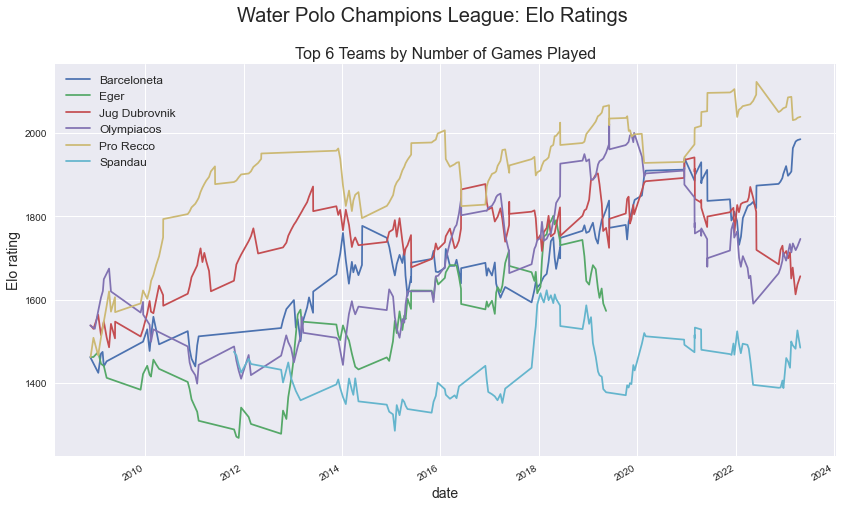

In [28]:
# plot the team Elo ratings over time
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(14,8))

num_teams = 6  #number of team to show in the plot
plot_teams = df_appear.head(num_teams).index
df_plot = df_elo_ts[df_elo_ts['team'].isin(plot_teams)]

for key, grp in df_plot.groupby('team'):
    ax = grp.plot(ax=ax, kind='line', x='date', y='elo', label=key)

ax.legend(loc='best', fontsize=12)
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('Elo rating', fontsize=14)
plt.suptitle('Water Polo Champions League: Elo Ratings', size=20)
plt.title(f'Top {num_teams} Teams by Number of Games Played', size=16)
#plt.show()

[Text(0.5, 0, 'first appearance'), Text(0, 0.5, 'matches played')]

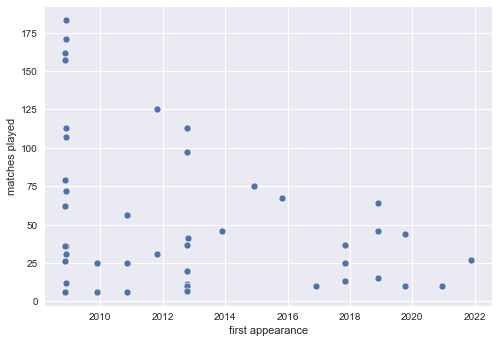

In [29]:
# visualize the relationship between first appearance and number of appearances
ax = sns.scatterplot(data=df_appear, x='first_app', y='num_app')
ax.set(xlabel='first appearance', ylabel='matches played')

<AxesSubplot:xlabel='prob_bucket', ylabel='draw_prob'>

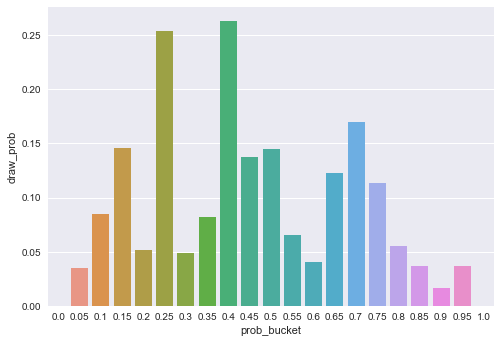

In [30]:
# visualize the historical draw rates based on the home team's Elo expected win odds
sns.barplot(data=draw_rates.reset_index(), x='prob_bucket', y='draw_prob')